We will use pre-trained YAMNet model

# Step 1: Load Model

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from utils.embedding_extraction import extract_embedding
from config.constants import PROCESSED_AUDIO_DATA_DIR, CLEANED_AUDIO_DATA_DIR

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow_hub')

print("YAMNet loaded successfully.")

C:\Users\Hakim\miniconda3\envs\tf_gpu\lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


YAMNet loaded successfully.


# Step 2: Prepare Data Set: Feature Extraction

In [3]:
# Assuming your CSV has columns: 'filename' and 'label'
csv_path = PROCESSED_AUDIO_DATA_DIR / "instruments.csv"
audio_folder = CLEANED_AUDIO_DATA_DIR

df = pd.read_csv(csv_path)

X = []
y = []

print("Extracting features (this may take a while)...")

for index, row in df.iterrows():
    file_path = audio_folder / row['filename']

    # Get the embedding
    emb = extract_embedding(file_path)

    if emb is not None:
        X.append(emb)
        y.append(row['label'])

X = np.array(X)
y = np.array(y)

print(f"Processed {len(X)} files.")
print(f"Feature shape: {X.shape}") # Should be (Number_of_files, 1024)

Extracting features (this may take a while)...
Processed 305979 files.
Feature shape: (305979, 1024)


# Step 3: Encode Labels: Split Data

In [4]:
# Convert string labels (e.g., "Guitar", "Piano") to integers (0, 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# Step 4: Build: Train Custom Classifier

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
model = models.Sequential([
    layers.Input(shape=(1024,)),         # Input is the 1024 vector from YAMNet
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),                 # Helps prevent overfitting
    layers.Dense(num_classes, activation='softmax') # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',       # watch validation loss
    patience=5,               # if no improvement for 5 epochs → stop
    restore_best_weights=True # load the best weights at the end
)

# Train
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
1913/1913 - 4s - loss: 1.1730 - accuracy: 0.5755 - val_loss: 0.9851 - val_accuracy: 0.6479 - 4s/epoch - 2ms/step
Epoch 2/50
1913/1913 - 3s - loss: 0.9572 - accuracy: 0.6487 - val_loss: 0.8524 - val_accuracy: 0.6898 - 3s/epoch - 2ms/step
Epoch 3/50
1913/1913 - 4s - loss: 0.8758 - accuracy: 0.6805 - val_loss: 0.9412 - val_accuracy: 0.6578 - 4s/epoch - 2ms/step
Epoch 4/50
1913/1913 - 4s - loss: 0.8152 - accuracy: 0.7017 - val_loss: 0.7494 - val_accuracy: 0.7327 - 4s/epoch - 2ms/step
Epoch 5/50
1913/1913 - 3s - loss: 0.7784 - accuracy: 0.7146 - val_loss: 0.7364 - val_accuracy: 0.7187 - 3s/epoch - 2ms/step
Epoch 6/50
1913/1913 - 3s - loss: 0.7466 - accuracy: 0.7256 - val_loss: 0.6672 - val_accuracy: 0.7575 - 3s/epoch - 2ms/step
Epoch 7/50
1913/1913 - 4s - loss: 0.7185 - accuracy: 0.7361 - val_loss: 0.6779 - val_accuracy: 0.7494 - 4s/epoch - 2ms/step
Epoch 8/50
1913/1913 - 4s - loss: 0.6989 - accuracy: 0.7428 - val_loss: 0.6726 - val_accuracy: 0.7597 - 4s/epoch - 2ms/step
Epoch 9/

# Step 5: Save Model and Classifier

In [10]:
import os
import pickle

from config.constants import MODELS_DIR

# --- CONFIGURATION ---
SAVE_DIR = MODELS_DIR
MODEL_NAME = 'instrument_classifier.h5'
ENCODER_NAME = 'label_encoder.pkl'

In [11]:
save_dir = MODELS_DIR
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. Create directory if it doesn't exist
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"Created directory: {SAVE_DIR}")

# 2. Save the Keras Model
model_path = os.path.join(SAVE_DIR, MODEL_NAME)
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# 3. Save the Label Encoder
# We need this to translate predictions (e.g., '0') back to text (e.g., 'Guitar')
le_path = os.path.join(SAVE_DIR, ENCODER_NAME)
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print(f"✅ Label Encoder saved to: {le_path}")

✅ Model saved to: C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\models\instrument_classifier.h5
✅ Label Encoder saved to: C:\Users\Hakim\Documents\ENSET\IA_Avance\musical-instrument-classifier\models\label_encoder.pkl


# Step 6: Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from utils.plot import plot_training_history

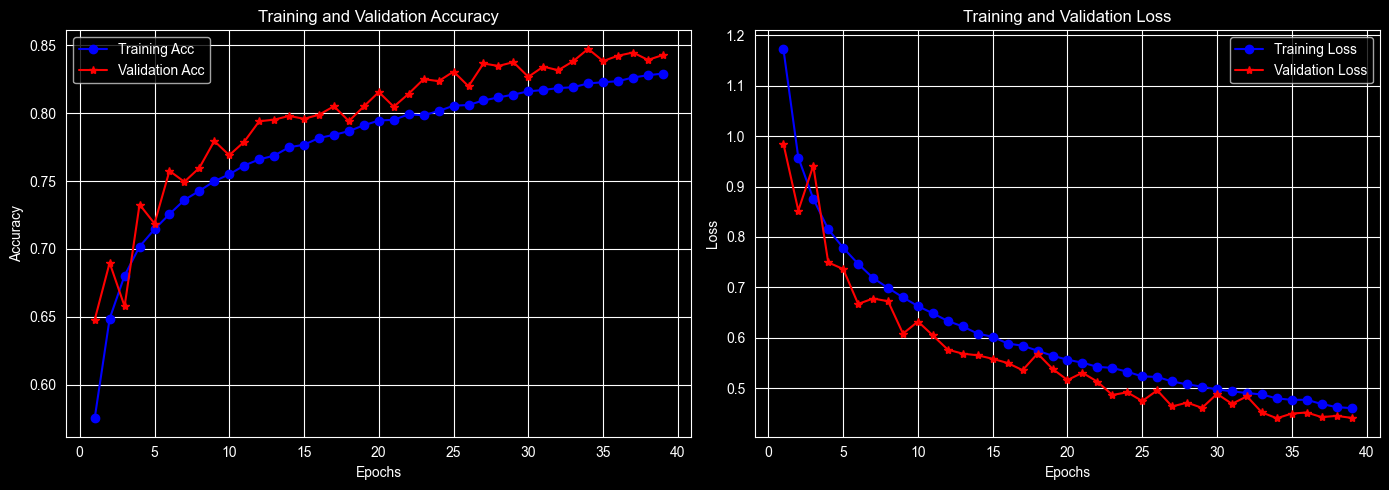

Generating predictions for Confusion Matrix...


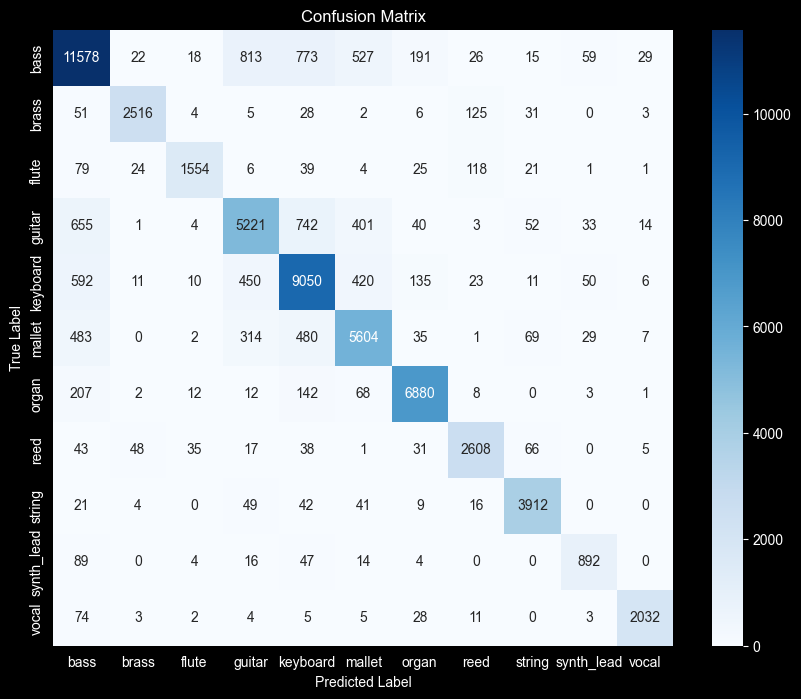

In [13]:
# Run the plotting function if training history exists
if 'history' in locals():
    plot_training_history(history)
else:
    print("⚠️ Variable 'history' not found. Please run the training cell first!")

# --- 2. Generate Confusion Matrix ---
print("Generating predictions for Confusion Matrix...")

# Get model predictions on the test set
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get Class Names (e.g., 'Guitar', 'Piano') from the LabelEncoder
class_names = le.classes_

# Create the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()